In [22]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pylab as plt
import warnings
from matplotlib.pylab import rcParams
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA,ARMA

warnings.filterwarnings('ignore')

In [23]:
# 读取数据，pd.read_csv默认生成DataFrame对象，需将其转换成Series对象
df_ori = pd.read_csv('../../dataset/HD-year.csv',header=0)
df_ori.index = pd.to_datetime(df_ori['Date'])  # 将字符串索引转换成时间索引
df=df_ori.asfreq(freq='3d',method='ffill')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,,
2018-02-01,2018-02-01,199.339996,202.250000,198.279999,199.899994,194.037582,3553800
2018-02-04,2018-02-02,199.250000,199.300003,193.440002,193.970001,188.281494,6179000
2018-02-07,2018-02-07,190.729996,194.520004,189.720001,191.289993,185.680084,6016800
2018-02-10,2018-02-09,183.250000,186.000000,175.789993,184.119995,178.720337,9059200
2018-02-13,2018-02-13,183.229996,183.990005,180.889999,183.720001,178.332092,4273800


In [24]:
def test_stationarity(timeseries):
    # 决定起伏统计
    rolmean = timeseries.rolling(12).mean()    # 对size个数据进行移动平均
    rol_weighted_mean = timeseries.ewm(span=12).mean() # 对size个数据进行加权移动平均
    rolstd = timeseries.rolling(12).std()    # 偏离原始值多少
    plt.figure(figsize=(20, 8))
    # 画出起伏统计
    orig = plt.plot(timeseries, color='blue',lw=1 ,label='Original')
    mean = plt.plot(rolmean, color='red',lw=1 ,label='Rolling Mean')
    weighted_mean = plt.plot(rol_weighted_mean, color='green', label='weighted Mean')
    std = plt.plot(rolstd, color='black',lw=1 ,label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    # 进行df测试
    print('Result of Dickry-Fuller test')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical value(%s)' % key] = value
    print(dfoutput)

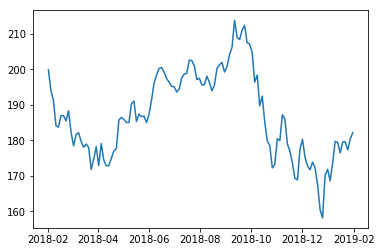

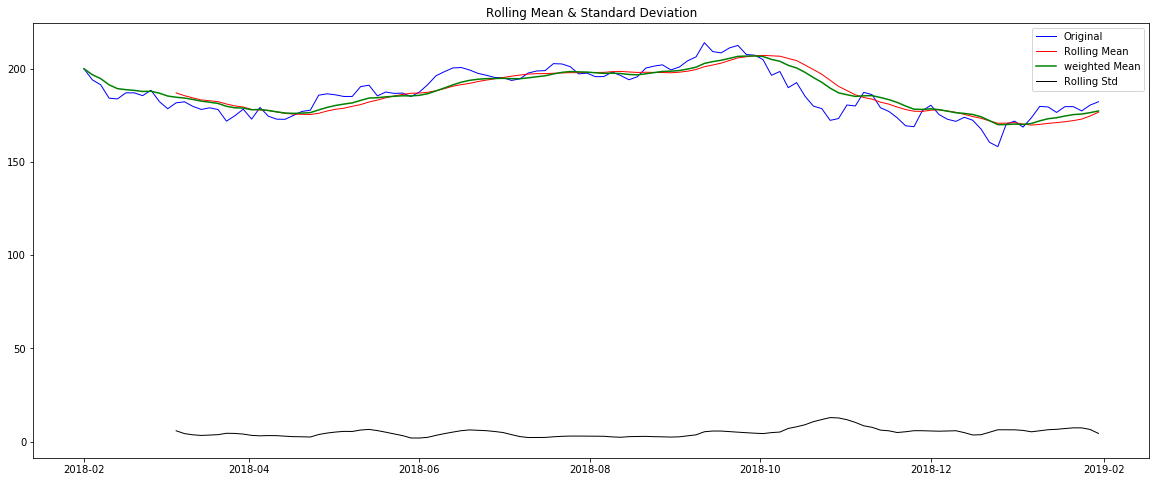

Result of Dickry-Fuller test
Test Statistic                  -1.887319
p-value                          0.338050
#Lags Used                       0.000000
Number of observations Used    121.000000
Critical value(1%)              -3.485585
Critical value(5%)              -2.885739
Critical value(10%)             -2.579676
dtype: float64


In [25]:
ts = df['Close']    
plt.plot(ts)
plt.show()
test_stationarity(ts)
plt.show()

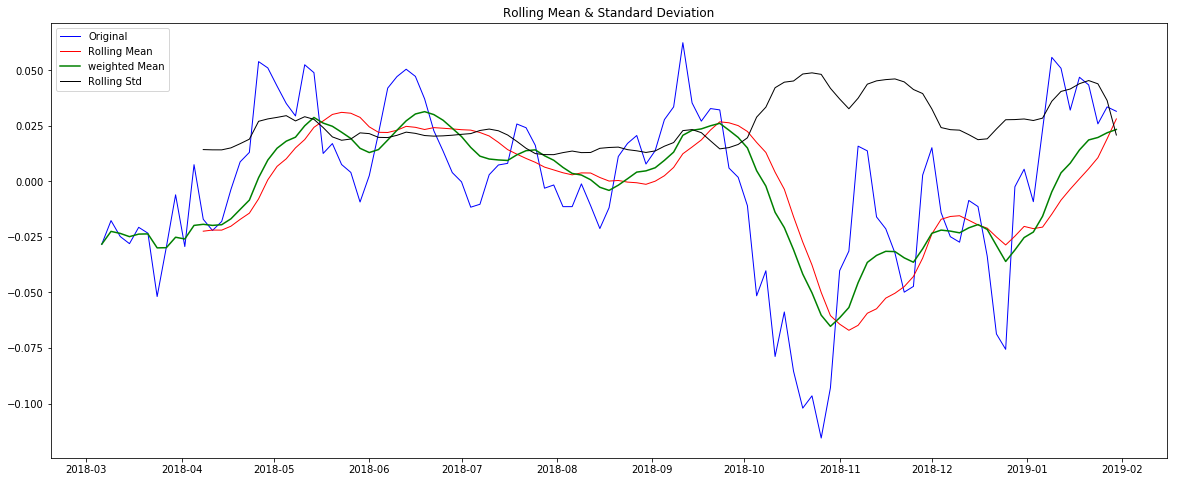

Result of Dickry-Fuller test
Test Statistic                  -3.014591
p-value                          0.033554
#Lags Used                       1.000000
Number of observations Used    109.000000
Critical value(1%)              -3.491818
Critical value(5%)              -2.888444
Critical value(10%)             -2.581120
dtype: float64


In [26]:
# estimating
ts_log = np.log(ts)
# plt.plot(ts_log)
# plt.show()
moving_avg = ts_log.rolling(12).mean()
# plt.plot(moving_avg)
# plt.plot(moving_avg,color='red')
# plt.show()
ts_log_moving_avg_diff = ts_log - moving_avg
# print ts_log_moving_avg_diff.head(12)
ts_log_moving_avg_diff.dropna(inplace=True)
test_stationarity(ts_log_moving_avg_diff)
plt.show()

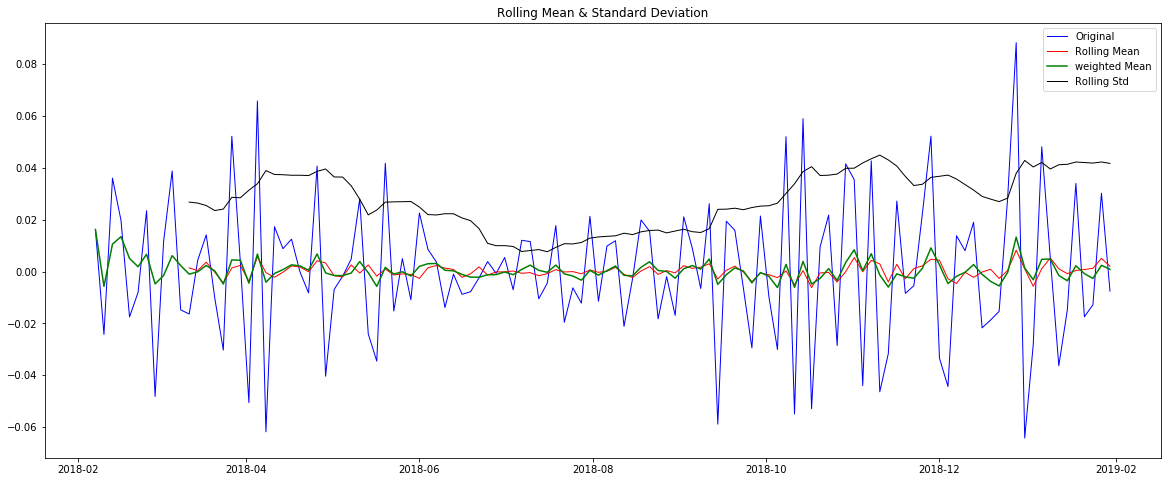

Result of Dickry-Fuller test
Test Statistic                -6.763768e+00
p-value                        2.750016e-09
#Lags Used                     8.000000e+00
Number of observations Used    1.110000e+02
Critical value(1%)            -3.490683e+00
Critical value(5%)            -2.887952e+00
Critical value(10%)           -2.580857e+00
dtype: float64


In [27]:
# 差分differencing
ts_log_diff_1 = ts_log.diff(1)
ts_log_diff_2 = ts_log_diff_1.diff(1)
ts_log_diff_1.dropna(inplace=True)
ts_log_diff_2.dropna(inplace=True)
test_stationarity(ts_log_diff_2)
plt.show()

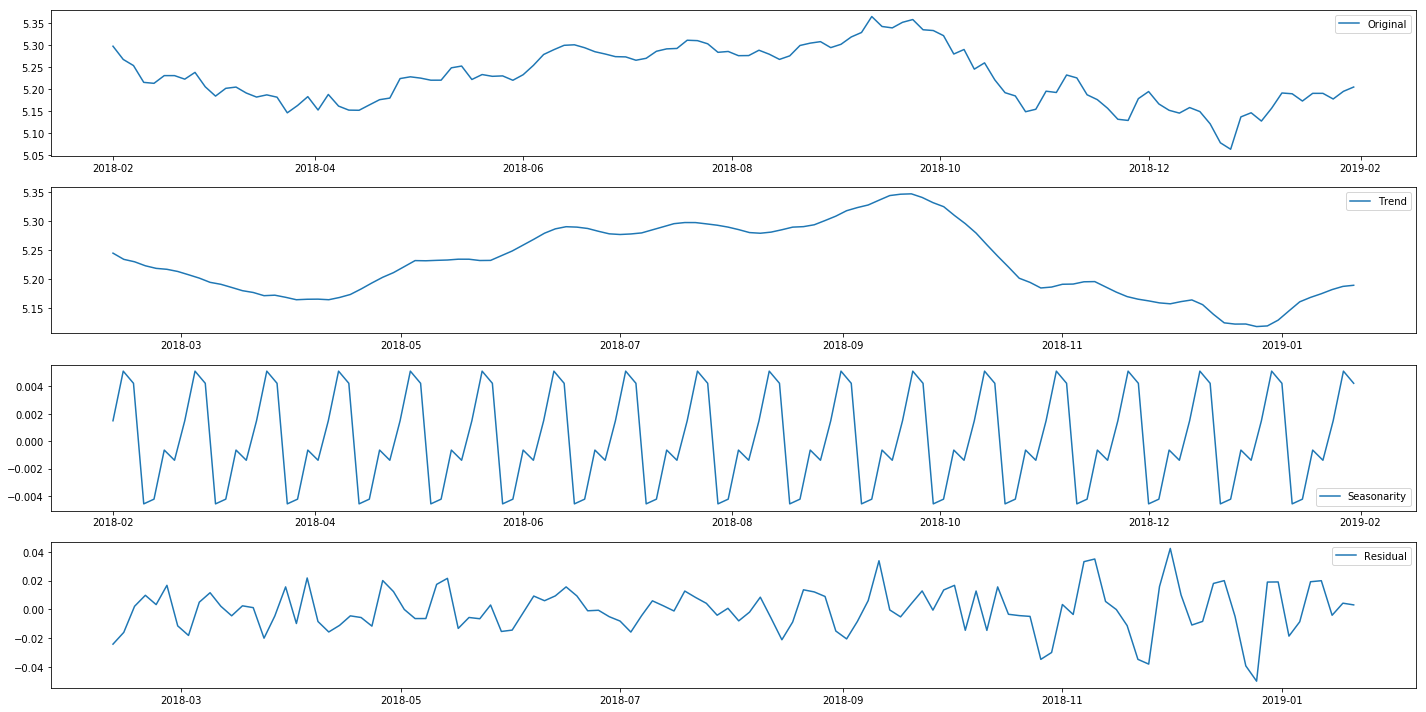

In [28]:
# 分解decomposing
decomposition = seasonal_decompose(ts_log)

trend = decomposition.trend  # 趋势
seasonal = decomposition.seasonal  # 季节性
residual = decomposition.resid  # 剩余的
plt.figure(figsize=(20, 10))
plt.subplot(411)
plt.plot(ts_log,label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend,label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonarity')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual,label='Residual')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [29]:
# import statsmodels.tsa.stattools as st
# order = st.arma_order_select_ic(ts_log,max_ar=5,max_ma=5,ic=['aic', 'bic', 'hqic'])
# order.bic_min_order

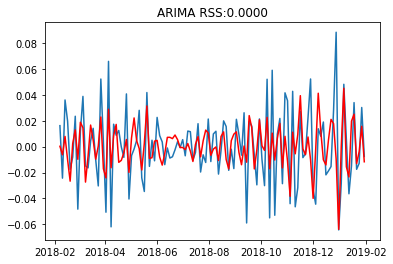

In [30]:
# ARIMA 将两个结合起来  效果更好
model = ARMA(ts_log_diff_2, order=(2,0))
result_ARIMA = model.fit(disp=-1)
plt.plot(ts_log_diff_2)
plt.plot(result_ARIMA.fittedvalues, color='red')
plt.title('ARIMA RSS:%.4f' % sum(result_ARIMA.fittedvalues - ts_log_diff_2) ** 2)
plt.show()

In [31]:
predict_ts = result_ARIMA.predict()
# 一阶差分还原
diff_shift_ts = ts_log_diff_1.shift(1)
diff_recover_1 = predict_ts.add(diff_shift_ts)
# 再次一阶差分还原
ts_log_shift_ts = ts_log.shift(1)
diff_recover = diff_recover_1.add(ts_log_shift_ts)
# 对数还原
log_recover = np.exp(diff_recover)
log_recover.dropna(inplace=True)

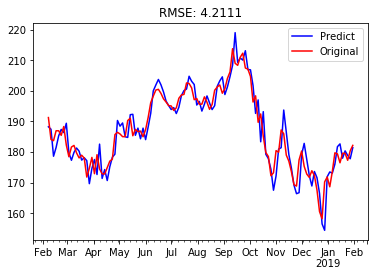

In [32]:
ts = ts[log_recover.index]  # 过滤没有预测的记录
plt.figure(facecolor='white')
log_recover.plot(color='blue', label='Predict')
ts.plot(color='red', label='Original')
plt.legend(loc='best')
plt.title('RMSE: %.4f'% np.sqrt(sum((log_recover-ts)**2)/ts.size))
plt.show()

In [33]:
from dateutil.relativedelta import relativedelta
future_day=30
predictions=list()
train=ts_log_diff_2.copy()

for i in range(future_day):
    model = ARMA(train.astype(np.float32), order=(2,0))
    model_fit=model.fit(disp=-1)
    yhat = model_fit.forecast()[0]
    new_index=train.index[-1]+relativedelta(days=3)
    train[new_index]=yhat
    predictions.append(yhat)
train.head()

Date
2018-02-07    0.0162007
2018-02-10   -0.0242899
2018-02-13     0.036028
2018-02-16    0.0197101
2018-02-19   -0.0175353
Freq: 3D, Name: Close, dtype: object

In [34]:
new_index=train.index[-1]+relativedelta(days=3)
train[new_index]=predictions[-1]
test_diff_2=train.copy()

In [35]:
diff_times = 2
first_values = []
time_series_diff=ts_log.copy()
for i in range(1, diff_times+1):
    first_values.append(pd.Series([time_series_diff[0]],index=[time_series_diff.index[0]]))
    time_series_diff = time_series_diff.diff(1).dropna()

time_series_restored = test_diff_2.copy()
for first in reversed(first_values):
    time_series_restored = first.append(time_series_restored).cumsum()
ts_re_index=time_series_restored.index
# 对数还原
log_recover = np.exp(np.array(time_series_restored,dtype=np.float32))
log_recover=pd.DataFrame(pd.Series(log_recover,index=ts_re_index))
log_recover.columns=['Close']
log_recover.head()

,Close
2018-02-01,199.899994
2018-02-04,193.970001
2018-02-07,191.289963
2018-02-10,184.119980
2018-02-13,183.719986


In [36]:
df_all=pd.read_csv('../../dataset/HD-year-now.csv',header=0)
df_all.index = pd.to_datetime(df_all['Date'])  # 将字符串索引转换成时间索引
df_all_3d=df_all.asfreq(freq='3d',method='ffill')
df_all_3d.head()
df_all_3d.shape

(152, 7)

In [37]:
df_all_3d.index

DatetimeIndex(['2018-02-01', '2018-02-04', '2018-02-07', '2018-02-10',
               '2018-02-13', '2018-02-16', '2018-02-19', '2018-02-22',
               '2018-02-25', '2018-02-28',
               ...
               '2019-04-03', '2019-04-06', '2019-04-09', '2019-04-12',
               '2019-04-15', '2019-04-18', '2019-04-21', '2019-04-24',
               '2019-04-27', '2019-04-30'],
              dtype='datetime64[ns]', name='Date', length=152, freq='3D')

In [38]:
type(time_series_restored)

pandas.core.series.Series

In [39]:
df_all_3d.shape

(152, 7)

In [40]:
print(log_recover.index)
print(df_all_3d.index)

DatetimeIndex(['2018-02-01', '2018-02-04', '2018-02-07', '2018-02-10',
               '2018-02-13', '2018-02-16', '2018-02-19', '2018-02-22',
               '2018-02-25', '2018-02-28',
               ...
               '2019-04-06', '2019-04-09', '2019-04-12', '2019-04-15',
               '2019-04-18', '2019-04-21', '2019-04-24', '2019-04-27',
               '2019-04-30', '2019-05-03'],
              dtype='datetime64[ns]', length=153, freq=None)
DatetimeIndex(['2018-02-01', '2018-02-04', '2018-02-07', '2018-02-10',
               '2018-02-13', '2018-02-16', '2018-02-19', '2018-02-22',
               '2018-02-25', '2018-02-28',
               ...
               '2019-04-03', '2019-04-06', '2019-04-09', '2019-04-12',
               '2019-04-15', '2019-04-18', '2019-04-21', '2019-04-24',
               '2019-04-27', '2019-04-30'],
              dtype='datetime64[ns]', name='Date', length=152, freq='3D')


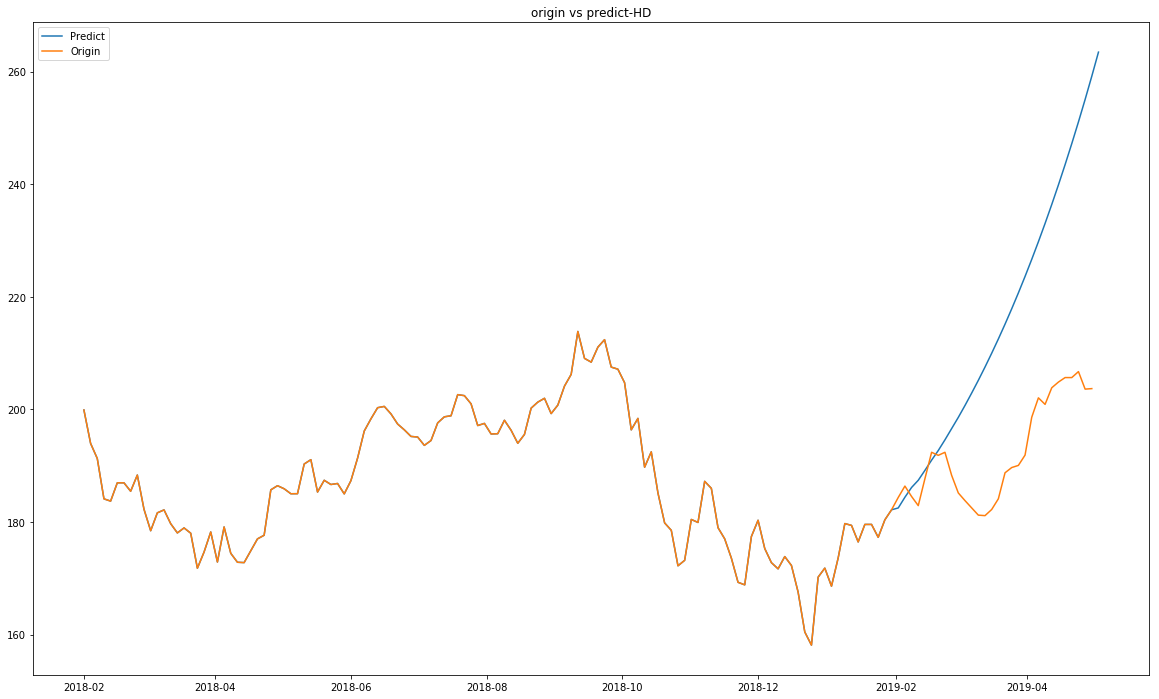

In [41]:
plt.figure(facecolor='white',figsize=(20,12))
plt.plot(log_recover,label='Predict')
plt.plot(df_all_3d['Close'],label='Origin')
plt.legend(loc='best')
plt.title("origin vs predict-HD")
plt.show()

In [42]:
#误差统计
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import math
pre=log_recover['2019-02-03':df_all_3d.index[-1]]
ori=df_all_3d['Close']['2019-02-03':]

avg=np.mean(ori)

rmse=math.sqrt(mean_squared_error(pre, ori))
mae=mean_absolute_error(pre,ori)

rmse_error_percentage=rmse/avg
mae_error_percentage=mae/avg
print('TEST RMSE: %.4f' % rmse)
print('TEST MAE: %.4f'% mae)
print("Test RMSE Error Percentage: %.2f/100.00" % (rmse_error_percentage * 100))
print("Test MAE Error Percentage: %.2f/100.00" % (mae_error_percentage * 100))

TEST RMSE: 28.1562
TEST MAE: 23.5364
Test RMSE Error Percentage: 14.63/100.00
Test MAE Error Percentage: 12.23/100.00
